# Aggregate-Label Learning (Draft)
A reproduction of the aggregate-label learning task using an implementation of the multi-spike tempotron in Julia. 
For further details see [Gütig, R. (2016). Spiking neurons can discover predictive features by aggregate-label learning. Science, 351(6277), aab4113.](https://science.sciencemag.org/content/351/6277/aab4113)

## Imports

In [8]:
using Tempotrons
using Tempotrons.InputGen
using Tempotrons.Plots
using Tempotrons.Optimizers
using ProgressMeter
using Plots;

## Set parameters

In [9]:
N = 500
T = 1000
dt = 0.1
t = collect(0:dt:T)
ν = 5
λ = 0.01
opt = SGD(λ, momentum = 0.99)
n_event_types = 10
event_length = 50
event_freq = 10
n_steps = 20000
n_test_samples = 10
tmp = Tempotron(N = N, τₘ = 20)
Pretrain!(tmp);

## Generate input events

In [10]:
events = GetEvents(n_event_types, event_length::Real, N = N, ν = ν);

## Set teacher's rule
Examples following Fig.1(B) from the [original paper](https://science.sciencemag.org/content/351/6277/aab4113). 

In [11]:
# y(event_types)::Integer = isempty(event_types) ? 0 : length(filter(x -> x == 2, event_types));    #1
# y(event_types)::Integer = isempty(event_types) ? 0 : 5*length(filter(x -> x == 2, event_types));  #2
# y(event_types)::Integer = isempty(event_types) ? 0 : length(filter(x -> x%2 == 0, event_types));  #3
# y(event_types)::Integer = isempty(event_types) ? 0 : sum(filter(x -> x%2 == 0, event_types)/2);   #4
y(event_types)::Integer = isempty(event_types) ? 0 : sum(filter(x -> x%5 == 0, event_types)/5);

## Generate test samples

In [12]:
test_samples = [GenerateSampleWithEmbeddedEvents(events, event_length = event_length, 
                                                 event_freq = event_freq, ν = ν, T = T)
                for j = 1:n_test_samples]
test_samples = [(ts..., y = y(ts.event_types)) for ts ∈ test_samples];

## Training

In [13]:
# Train the tempotron
@showprogress 1 "Training..." for i = 1:n_steps
    x, event_types, ~ = GenerateSampleWithEmbeddedEvents(events, event_length = event_length, 
                                                         event_freq = event_freq, ν = ν, T = T)
    Train!(tmp, x, y(event_types), optimizer = opt)
end

# Get the tempotron's output after training
out_a = [tmp(s.x, t = t).V for s ∈ test_samples];

Training...100%|████████████████████████████████████████| Time: 0:32:03


## Plots

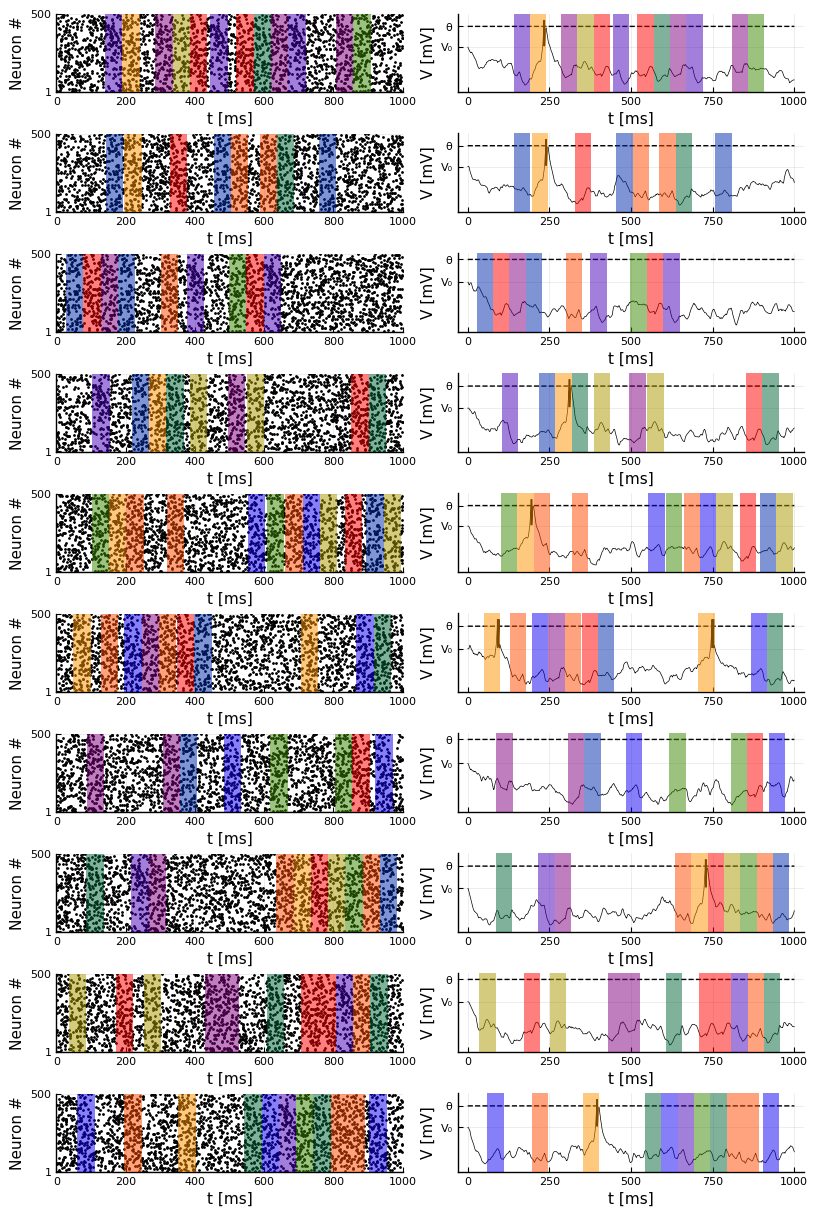

In [14]:
# Prepare to plot
pyplot(size = (800, 1200))
clibrary(:misc)
cols = RGB[cgrad(:rainbow)[z] for z = range(0, stop = 1, length = n_event_types)]
test_events = [[(time = s.event_times[i], length = event_length, color = cols[s.event_types[i]])
                for i = 1:length(s.event_times)] 
               for s ∈ test_samples]

# Plots
inp_plots = [PlotInputs(test_samples[i].x, T_max = T, events = test_events[i])
             for i = 1:length(test_samples)]
train_plots = [PlotPotential(tmp, out = out_a[i],
                             t = t, events = test_events[i])
               for i = 1:length(test_samples)]
ps = [reshape(inp_plots, 1, :);
      reshape(train_plots, 1, :)]
plot(ps[:]..., layout = (length(inp_plots), 2), link = :x)
savefig("AggLabels.png");